In [5]:
import sparknlp
import numpy as np
# Import the required modules and classes
from sparknlp.base import DocumentAssembler, Pipeline, Finisher

from sparknlp.annotator import (
    SentenceDetector,
    Tokenizer,
    Lemmatizer,
    SentimentDetector
)
import pyspark.sql.functions as F
# Start Spark Session

from sparknlp.pretrained import PretrainedPipeline
import afinn
from pyspark.sql import types
import yahooquery as yq
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns

In [6]:
spark = sparknlp.start()

In [7]:
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/lemma-corpus-small/lemmas_small.txt -P /tmp
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/default-sentiment-dict.txt -P /tmp

--2024-05-11 19:05:35--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/lemma-corpus-small/lemmas_small.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.104.8, 52.217.174.104, 16.182.99.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.104.8|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘/tmp/lemmas_small.txt’ not modified on server. Omitting download.

--2024-05-11 19:05:35--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/default-sentiment-dict.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.174.104, 3.5.24.43, 16.182.104.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.174.104|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘/tmp/default-sentiment-dict.txt’ not modified on server. Omitting download.



In [8]:


# Step 1: Transforms raw texts to `document` annotation
document_assembler = (
    DocumentAssembler() \
    .setInputCol("article") \
    .setOutputCol("document")
)

# Step 2: Sentence Detection
sentence_detector = SentenceDetector().setInputCols(["document"]).setOutputCol("sentence")

# Step 3: Tokenization
tokenizer = Tokenizer().setInputCols(["sentence"]).setOutputCol("token")

# Step 4: Lemmatization
lemmatizer= Lemmatizer().setInputCols("token").setOutputCol("lemma") \
                        .setDictionary("lemmas_small.txt", key_delimiter="->", value_delimiter="\t")

# Step 5: Sentiment Detection
sentiment_detector= (
    SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("default-sentiment-dict.txt", ",")
)

# Step 6: Finisher
finisher= (
    Finisher() \
    .setInputCols(["sentiment_score"]).setOutputCols("sentiment")
)

# Define the pipeline
pipeline = Pipeline(
    stages=[
        document_assembler,
        sentence_detector, 
        tokenizer, 
        lemmatizer, 
        sentiment_detector, 
        finisher
    ]
)

def compute_with_afinn(text):

    return afinn.Afinn().score(text)

compute_sentiment_score_udf = F.udf(compute_with_afinn, types.FloatType())

In [9]:
# Create a spark Data Frame with an example sentence
data = spark.createDataFrame(
    [
        [
            "The restaurant staff is really nice"
        ]
    ]
).toDF("text") # use the column name `text` defined in the pipeline as input

data = spark.read.option("header","true").json("../data/json/NVIDIA/")
data = data.select("published date","article")

# Fit-transform to get predictions


ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/home/alber/.local/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alber/.local/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

KeyboardInterrupt



In [45]:
result = pipeline.fit(data).transform(data)

In [46]:
result.columns

['published date', 'article', 'sentiment']

In [48]:
result = result.withColumn("afinn_sentiment",compute_sentiment_score_udf(F.col('article')))

In [58]:
df = result.toPandas()
df['sentiment'] = df['sentiment'].apply(lambda x: x[0])
df['sentiment'] = np.where(df['sentiment'] == 'positive',1,np.where(df['sentiment']=='negative',-1,0))
df['published date'] = df['published date'].apply(lambda x: " ".join(x.split(",")[1].split(" ")[:4]).strip())

In [59]:
df

,published date,article,sentiment,afinn_sentiment
0,17 Dec 2021,3.53 -13%\n\n3.54 -13%\n\n3.6 -11%\n\n3.61 -11...,1,-14.0
1,03 Jan 2017,3.12 -12%\n\n3.13 -11%\n\n3.16 -10%\n\n3.34 -5...,1,-83.0
2,03 Jan 2017,3.12 -12%\n\n3.13 -11%\n\n3.16 -10%\n\n3.34 -5...,1,-83.0
3,05 Sep 2019,6.69 -8%\n\n6.72 -8%\n\n6.75 -8%\n\n6.76 -7%\n...,1,-98.0
4,08 Jan 2019,11.6 -7%\n\n11.8 -6%\n\n11.9 -5%\n\n12 -4%\n\n...,1,1734.0
...,...,...,...,...
45116,10 Dec 2019,,1,0.0
45117,23 Sep 2023,"""NaN""",1,0.0
45118,27 Apr 2021,,1,0.0
45119,08 Mar 2017,,1,0.0


In [75]:
min_max = MinMaxScaler((-1,1))
std_scaler = StandardScaler()


In [91]:
model_df = df.copy()
model_df['date'] = model_df['published date'].apply(lambda x: dt.datetime.strptime(x, "%d %b %Y").strftime("%Y-%m-%d"))

model_df = model_df[['date','sentiment','afinn_sentiment']]
# date_obj = 

# Convert to the desired format
# formatted_date = 
# pd.to_datetime(model_df['published date'],format="%Y-%m-%d")

min_max_results = min_max.fit_transform(model_df['afinn_sentiment'].values.reshape(-1,1))
std_results = std_scaler.fit_transform(model_df['afinn_sentiment'].values.reshape(-1,1))

model_df['min_max_afinn'] = min_max_results
model_df['std_afinn'] = std_results
model_df['div_to_max'] = model_df['afinn_sentiment']/model_df['afinn_sentiment'].max()
model_df = model_df.groupby("date").sum().reset_index()

In [92]:
model_df

,date,sentiment,afinn_sentiment,min_max_afinn,std_afinn,div_to_max
0,2017-01-02,1.000000,35.000000,-0.674717,0.160808,0.020185
1,2017-01-03,0.666667,13.500000,-0.695909,-0.342693,0.007785
2,2017-01-04,1.000000,19.590910,-0.689905,-0.200052,0.011298
3,2017-01-05,0.913043,23.108696,-0.686438,-0.117671,0.013327
4,2017-01-06,1.000000,17.428572,-0.692037,-0.250691,0.010051
...,...,...,...,...,...,...
2565,2024-04-13,0.692308,29.538462,-0.680100,0.032906,0.017035
2566,2024-04-14,0.958333,39.750000,-0.670034,0.272046,0.022924
2567,2024-04-15,1.000000,7.307693,-0.702013,-0.487709,0.004214
2568,2024-04-16,0.910112,21.235954,-0.688284,-0.161528,0.012247


In [95]:
model_df['date'] = pd.to_datetime(model_df['date'])

In [98]:
model_df.date.max(),model_df.date.min()


(Timestamp('2024-04-17 00:00:00'), Timestamp('2017-01-02 00:00:00'))

In [99]:
price = yq.Ticker("NVDA").history(start='2017-01-02')
price

/home/alber/.local/lib/python3.11/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/home/alber/.local/lib/python3.11/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/home/alber/.local/lib/python3.11/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to b

open        high         low       close     volume  \
symbol date                                                                    
NVDA   2017-01-03   26.100000   26.592501   24.844999   25.502501  150199600   
       2017-01-04   25.850000   26.375000   25.382500   26.097500  119922000   
       2017-01-05   26.132500   26.455000   25.262501   25.434999   98429600   
       2017-01-06   25.712500   26.062500   25.299999   25.775000   82285600   
       2017-01-09   25.875000   27.000000   25.875000   26.820000   91624800   
...                       ...         ...         ...         ...        ...   
       2024-05-06  893.900024  922.200012  890.549988  921.400024   37620300   
       2024-05-07  910.979980  917.809998  823.250000  905.539978   43734200   
       2024-05-08  894.830017  911.940002  894.200012  904.119995   32572100   
       2024-05-09  905.289978  910.719971  882.309998  887.469971   37801300   
       2024-05-10  903.049988  914.010010  892.270020  898.780029   33455700   

                     adjclose  dividends  splits  
symbol date                                       
NVDA   2017-01-03   25.134892        0.0     0.0  
       2017-01-04   25.721317        0.0     0.0  
       2017-01-05   25.068359        0.0     0.0  
       2017-01-06   25.403456        0.0     0.0  
       2017-01-09   26.433395        0.0     0.0  
...                       ...        ...     ...  
       2024-05-06  921.400024        0.0     0.0  
       2024-05-07  905.539978        0.0     0.0  
       2024-05-08  904.119995        0.0     0.0  
       2024-05-09  887.469971        0.0     0.0  
       2024-05-10  898.780029        0.0     0.0  

[1851 rows x 8 columns]

In [128]:
price_df = price.reset_index()[['date','adjclose']]
price_df['return'] = price_df['adjclose'].pct_change(1)
price_df = price_df[['date','return']]

In [130]:
price_df['date'] = pd.to_datetime(price_df['date'])

In [131]:
final_df = model_df.merge(price_df,on='date',how='right')

In [132]:
final_df.dropna(inplace=True)

In [133]:
final_df

,date,sentiment,afinn_sentiment,min_max_afinn,std_afinn,div_to_max,return
1,2017-01-04,1.000000,19.590910,-0.689905,-0.200052,0.011298,0.023331
2,2017-01-05,0.913043,23.108696,-0.686438,-0.117671,0.013327,-0.025386
3,2017-01-06,1.000000,17.428572,-0.692037,-0.250691,0.010051,0.013367
4,2017-01-09,1.000000,23.142857,-0.686404,-0.116871,0.013347,0.040543
5,2017-01-10,0.600000,20.000000,-0.689502,-0.190472,0.011534,-0.007550
...,...,...,...,...,...,...,...
1829,2024-04-11,0.836066,20.819672,-0.688694,-0.171276,0.012007,0.041096
1830,2024-04-12,0.600000,6.000000,-0.703302,-0.518333,0.003460,-0.026816
1831,2024-04-15,1.000000,7.307693,-0.702013,-0.487709,0.004214,-0.024777
1832,2024-04-16,0.910112,21.235954,-0.688284,-0.161528,0.012247,0.016442


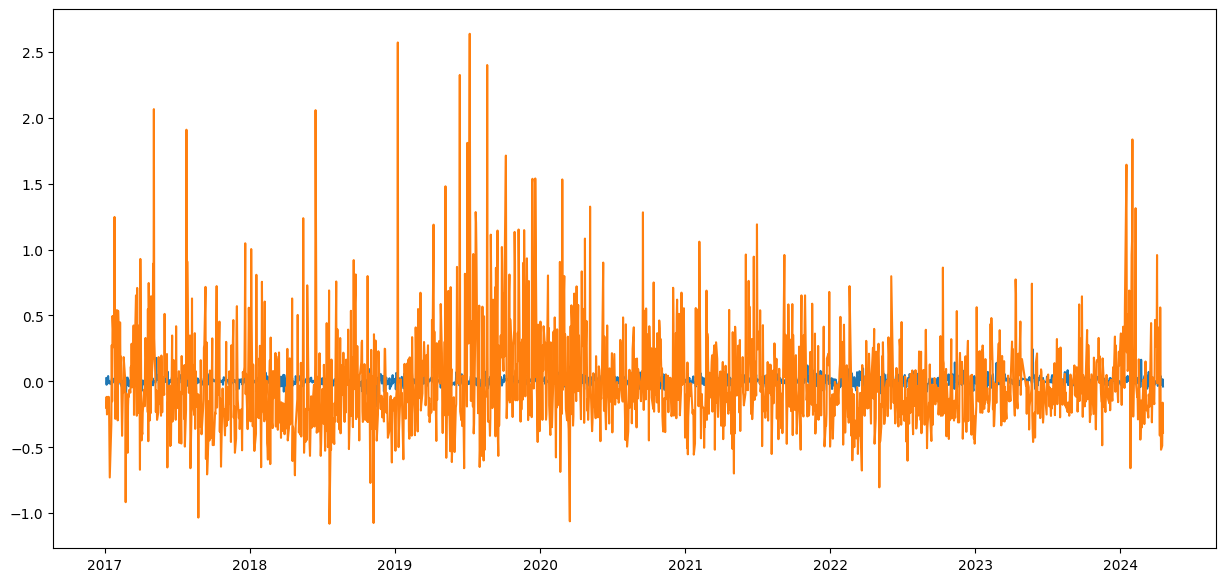

In [139]:
plt.figure(figsize=(15,7))
plt.plot(final_df['date'],final_df['return'])
plt.plot(final_df['date'],final_df['std_afinn'])

In [140]:
corr = final_df.corr()

<Axes: >

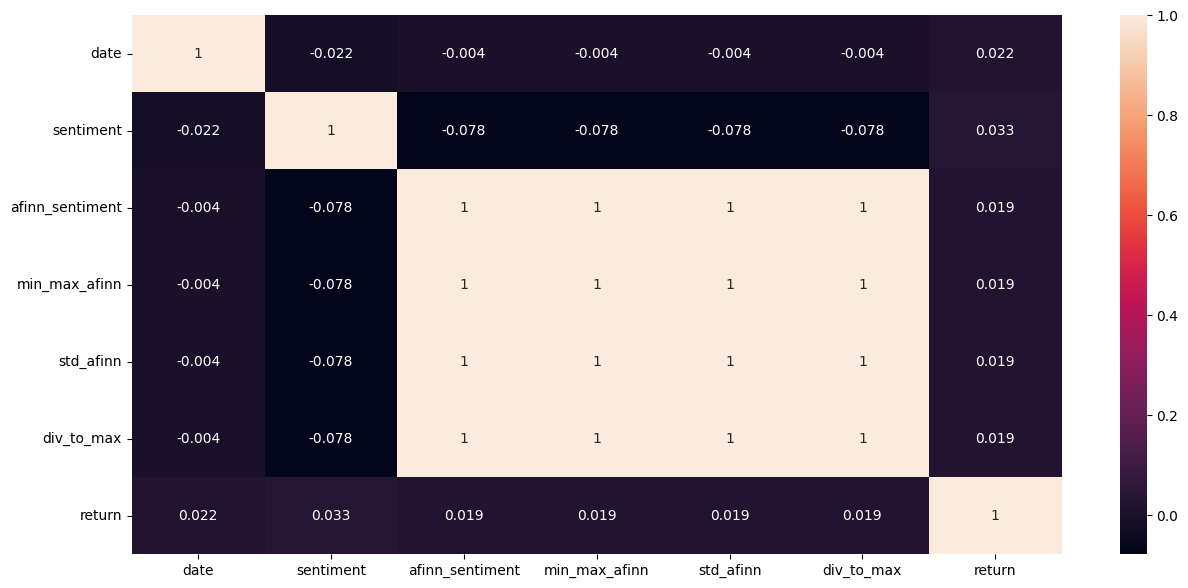

In [141]:
plt.figure(figsize=(15,7))
sns.heatmap(corr,annot=True)

In [195]:
reg_df = final_df.copy()
reg_df = final_df[['sentiment','std_afinn','return']]
reg_df['next_day_return'] = reg_df['return'].shift(-1)
reg_df['label'] = np.where(reg_df['next_day_return']<=0,0,1)
reg_df.dropna(inplace=True)

/tmp/ipykernel_17355/3001637256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['next_day_return'] = reg_df['return'].shift(-1)
/tmp/ipykernel_17355/3001637256.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['label'] = np.where(reg_df['next_day_return']<=0,0,1)
/tmp/ipykernel_17355/3001637256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [196]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR,SVC

In [197]:
model = LinearRegression()
X,y = reg_df.iloc[:,:3].values,reg_df.iloc[:,3]

n = len(X)
train_size = int(0.8*n)

X_train,X_test = X[:train_size],X[train_size:]
y_train,y_test = y[:train_size],y[train_size:]

In [198]:
model = model.fit(X_train,y_train)

In [199]:
model.score(X_train,y_train)

0.008880090140080399

In [200]:
model.score(X_test,y_test)

-0.030101880149937754

In [201]:
svm = SVR()

In [202]:
svm = svm.fit(X_train,y_train)

In [203]:
svm.score(X_train,y_train)

-0.25950666675557543

In [204]:
svm.score(X_test,y_test)

-0.30037204233146886

In [205]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [206]:
X,y = reg_df.iloc[:,:3].values,reg_df.iloc[:,4]

n = len(X)
train_size = int(0.8*n)

X_train,X_test = X[:train_size],X[train_size:]
y_train,y_test = y[:train_size],y[train_size:]

In [207]:
log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train,y_train)

In [208]:
log_reg.score(X_train,y_train),log_reg.score(X_test,y_test)

(0.5379834254143646, 0.5619834710743802)

In [209]:
svc = SVC()
svc = svc.fit(X_train,y_train)

In [210]:
svc.score(X_train,y_train),svc.score(X_test,y_test)

(0.5455801104972375, 0.5674931129476584)

In [211]:
forest = RandomForestClassifier(n_estimators=66,max_depth=5)
forest = forest.fit(X_train,y_train)
forest.score(X_train,y_train),forest.score(X_test,y_test)

(0.6498618784530387, 0.5316804407713499)

In [212]:
knn = KNeighborsClassifier(n_neighbors=7)
knn = knn.fit(X_train,y_train)
knn.score(X_train,y_train),knn.score(X_test,y_test)

(0.6401933701657458, 0.5674931129476584)

In [188]:
reg_df

,sentiment,std_afinn,return,next_day_return,label
1,1.000000,-0.200052,0.023331,-0.025386,-1
2,0.913043,-0.117671,-0.025386,0.013367,1
3,1.000000,-0.250691,0.013367,0.040543,1
4,1.000000,-0.116871,0.040543,-0.007550,-1
5,0.600000,-0.190472,-0.007550,-0.012304,-1
...,...,...,...,...,...
1828,0.882353,0.560991,0.019741,0.041096,1
1829,0.836066,-0.171276,0.041096,-0.026816,-1
1830,0.600000,-0.518333,-0.026816,-0.024777,-1
1831,1.000000,-0.487709,-0.024777,0.016442,1


In [189]:
reg_df.value_counts("label")

label
 1    983
-1    828
Name: count, dtype: int64

In [215]:
xgb = XGBClassifier(max_depth=5)
xgb = xgb.fit(X_train,y_train.values.reshape(-1,1))
xgb.score(X_train,y_train),xgb.score(X_test,y_test)

(0.9005524861878453, 0.5234159779614325)

In [216]:
reg_df

,sentiment,std_afinn,return,next_day_return,label
1,1.000000,-0.200052,0.023331,-0.025386,0
2,0.913043,-0.117671,-0.025386,0.013367,1
3,1.000000,-0.250691,0.013367,0.040543,1
4,1.000000,-0.116871,0.040543,-0.007550,0
5,0.600000,-0.190472,-0.007550,-0.012304,0
...,...,...,...,...,...
1828,0.882353,0.560991,0.019741,0.041096,1
1829,0.836066,-0.171276,0.041096,-0.026816,0
1830,0.600000,-0.518333,-0.026816,-0.024777,0
1831,1.000000,-0.487709,-0.024777,0.016442,1


### LSTM

In [ ]:
from elephant import *
from pyspark.sql import SparkSession
from elephant import layers
from elephant.spark_model_bundler import SparkModelBundler
from pyspark.ml.evaluation import RegressionEvaluator

layers.s